# Imports

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from urllib.parse import unquote
import numpy as np
import plotly.express as px

# To Extract all the URLs from the HTM page
from bs4 import BeautifulSoup
import os

import networkx as nx
from datetime import datetime

# Draw the graph
import seaborn as sns

from helpers import (
    extract_links,
    change_characters,
    path_to_name,
    get_gender_for_name,
    add_all_genders
    )   


# Preprocessing

## Downloading the dataset

In [30]:
# Paths
folder_path = "dataset/wikispeedia_paths-and-graph/"
file_paths = ["paths_finished.tsv", "paths_unfinished.tsv", "categories.tsv", "articles.tsv", "links.tsv"]

# Datasets: Names and their columns name
data_frames_names = ["paths_finished", "paths_unfinished", "categories", "article", "links"]
dfs_headers = [
    ["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"],
    ["hashedIpAddress", "timestamp", "durationInSec", "path", "target", "type"],
    ["article", "category"],
    ["article"],
    ["linkSource", "linkTarget"]
]

# Download
dfs_skiprows = [16, 17, 13, 12, 12]
dfs = {}
for i in range(len(file_paths)):
    dfs[data_frames_names[i]] = pd.read_csv(folder_path + file_paths[i], sep='\t', header=None, names=dfs_headers[i], skiprows=range(dfs_skiprows[i]))

## Functions

In [31]:
def dataset_info(dictionary, dataset_name):
    """ Display main information about a specified dataset from the given dictionary.
    params:
        dictionnary: dict
            A dictionary of dataframes.
        dataset_name: str 
            The name of the dataframe to be accessed in the dictionary
     """
    # Print the dataset name we are working on
    print('{}:'.format(dataset_name))

    df = dictionary[dataset_name]
    print('\tShape of the dataset: {}'.format(df.shape))
    

     # Check for NaN values in each column
    columns_with_nan = df.columns[df.isna().any()].tolist()

    # Print the columns with NaN values if they exsit
    if columns_with_nan == []:
        print('\tThe dataset has no column with NaN values.\n')
    else:
        print('\tThe dataset has {} columns with NaN values: {}\n'.format(len(columns_with_nan), columns_with_nan))
    
    # Provide statistical info 
    print('Visualisation of the first column and statistical infos:')
    display(df.head(1))
    display(df.describe(include='all'))
    df.info()

## Format & missing values

### Finished paths dataset

In [32]:
dataset_info(dfs, 'paths_finished')

paths_finished:
	Shape of the dataset: (51318, 5)
	The dataset has 2 columns with NaN values: ['hashedIpAddress', 'rating']

Visualisation of the first column and statistical infos:


,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN


,hashedIpAddress,timestamp,durationInSec,path,rating
count,51315,5.131800e+04,51318.000000,51318,28501.000000
unique,14244,NaN,NaN,47856,NaN
top,0d57c8c57d75e2f5,NaN,NaN,Brain;Computer_science;Information;Communicati...,NaN
freq,4865,NaN,NaN,144,NaN
mean,NaN,1.296384e+09,158.276199,NaN,2.269780
std,NaN,4.935086e+07,360.841904,NaN,1.110439
min,NaN,1.219095e+09,0.000000,NaN,1.000000
25%,NaN,1.250109e+09,60.000000,NaN,1.000000
50%,NaN,1.283894e+09,107.000000,NaN,2.000000
75%,NaN,1.345231e+09,183.000000,NaN,3.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51318 entries, 0 to 51317
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   hashedIpAddress  51315 non-null  object 
 1   timestamp        51318 non-null  int64  
 2   durationInSec    51318 non-null  int64  
 3   path             51318 non-null  object 
 4   rating           28501 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 2.0+ MB


#### Observations

- The *finish path* dataset consists of 5 columns: 
    - **hashedIpAddress:** The IP adresses that allows to identify different players. 
    - **timestamp:**  A sequence of characters indicating the current time of an event, in this case, playing Wikispeedia, recorded by the computer.
    - **durationInsec:** The duration it tooks for the player to link the source article to the target. 
    - **path:** Each path taken to link a source article to the target.
    - **rating:** An optional evaluation made by the player to assess the difficulty encountered in linking the source to the target article.

* From the count and unique information, the following observations can be made:
    * There are 14,244 unique hashedIpAddress out of 51,315 Ip addresses, meaning that the users are playing the game multiple times. 
    * Some players are taking the same path as there are 47,856 unique paths out of 51,318. 
    
- The dataset contains missing values in hashedIpAddress and rating columns. For our analysis, we will not use the information from those two columns, so handling missing values is not necessary for now. Therfore we will just remove those columns from the dataset for the further analysis. If needed, one option for handling missing values in hashedIpAddress is to remove corresponding rows, as only 3 out of 51,318 values are missing. For the rating missing values, around 55% of the values are missing, simply removing them may result in a significant reduction in the dataset size and introduce bias. A better approach would be to predict their values and replace the NaN entries with those predictions or replace NaN with another value manageable for the task at hand.

- We observed that in the path column, some characters are not correctly translated (%.. format). We need to correct them.

#### Adjustments

In [33]:
dfs = change_characters(dfs, 'paths_finished', 'path')
dfs['paths_finished'] = dfs['paths_finished'].drop(['hashedIpAddress', 'rating'], axis = 1)
display(dfs['paths_finished'])

,timestamp,durationInSec,path
0,1297740409,166,14th_century;15th_century;16th_century;Pacific...
1,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...
2,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...
3,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece
4,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...
...,...,...,...
51313,1349231015,66,Yagan;Ancient_Egypt;Civilization
51314,1300254138,165,Yagan;Folklore;Brothers_Grimm;<;19th_century;C...
51315,1385095372,228,Yagan;Australia;England;France;United_States;T...
51316,1298792567,56,"Yarralumla,_Australian_Capital_Territory;Austr..."


### Unfinished paths dataset

In [34]:
dataset_info(dfs, 'paths_unfinished')

paths_unfinished:
	Shape of the dataset: (24875, 6)
	The dataset has no column with NaN values.

Visualisation of the first column and statistical infos:


,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout


,hashedIpAddress,timestamp,durationInSec,path,target,type
count,24875,2.487500e+04,24875.000000,24875,24875,24875
unique,11485,NaN,NaN,20982,3766,2
top,26f76e394525328e,NaN,NaN,Brain,Telephone,restart
freq,163,NaN,NaN,213,1060,15552
mean,NaN,1.344763e+09,835.296884,NaN,NaN,NaN
std,NaN,2.772317e+07,881.287961,NaN,NaN,NaN
min,NaN,1.297055e+09,4.000000,NaN,NaN,NaN
25%,NaN,1.320339e+09,86.000000,NaN,NaN,NaN
50%,NaN,1.348587e+09,261.000000,NaN,NaN,NaN
75%,NaN,1.367373e+09,1831.000000,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24875 entries, 0 to 24874
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   hashedIpAddress  24875 non-null  object
 1   timestamp        24875 non-null  int64 
 2   durationInSec    24875 non-null  int64 
 3   path             24875 non-null  object
 4   target           24875 non-null  object
 5   type             24875 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.1+ MB


#### Observations

- The *unfinish path* dataset consists of 6 columns: 
    - **hashedIpAddress:** The IP adresses that allows to identify different players. 
    - **timestamp:**  A sequence of characters indicating the current time of an event, in this case, playing Wikispeedia, recorded by the computer.
    - **durationInsec:** The duration it tooks for the player to link the source article to the target. 
    - **path:** Each path taken to link a source article to the target.
    - **target:** The name of the target article the player would ideally reach.
    - **type:** The reason for which the path is unfinished, categorized into two types: timeout and restart.

* From the count and unique information, the following observations can be made:
    * There as for the finished paths, since there is a smaller number of unique hashedIpAddress than the total count, we can conclude that users are playing the game multiple times. 
    * Some players are taking the same path. The most represented unfinished path is *brain* (a path consisting of only one article), implying that some unfinished paths may result from players that do not like the source and target combination and choosing to restart.
    
 - There are no missing values. 

- We observed that in the path and target columns, some characters are not correctly translated (%.. format). We need to correct them.

#### Adjustments

In [35]:
dfs = change_characters(dfs, 'paths_unfinished', 'path')
dfs = change_characters(dfs, 'paths_unfinished', 'target')
display(dfs['paths_unfinished'])

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout
...,...,...,...,...,...,...
24870,109ed71f571d86e9,1389787605,180,Franz_Kafka;Tuberculosis;World_Health_Organiza...,Cholera,restart
24871,232f992e57d43e8d,1389787697,6,Modern_history,Hollandic,restart
24872,2e09a7224600a7cd,1389798400,1900,Computer_programming;Linguistics;Culture;Popul...,The_Beatles,timeout
24873,60af9e2138051b96,1389799481,1903,Jamaica;United_Kingdom;World_War_II;Battle_of_...,Alan_Turing,timeout


### Categories dataset

In [36]:
dataset_info(dfs, 'categories')

categories:
	Shape of the dataset: (5204, 2)
	The dataset has no column with NaN values.

Visualisation of the first column and statistical infos:


,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...


,article,category
count,5204,5204
unique,4598,129
top,Pottery,subject.Countries
freq,3,229


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5204 entries, 0 to 5203
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   article   5204 non-null   object
 1   category  5204 non-null   object
dtypes: object(2)
memory usage: 81.4+ KB


#### Observations

- The _categories_ dataset consists of 2 columns: 
    - **article:** The name of the article.
    - **category:**  The corresponding categories to which the articles belong. The category is a sequence of sub-categories separated by a point.

* From the count and unique information, the following observations can be made:
    * There are 4,598 unique articles out of 5,204, meanings some articles have more than one category path within the 129 possible. 
    
 - There are no missing values. 

- We observed that in the article columns, some characters are not correctly translated (%.. format). We need to correct them. To be sure there are no similar issues in the category column, we will also check and correct them.


#### Adjustments

In [37]:
dfs = change_characters(dfs, 'categories', 'article')
dfs = change_characters(dfs, 'categories', 'category')
display(dfs['categories'])

,article,category
0,Áedán_mac_Gabráin,subject.History.British_History.British_Histor...
1,Áedán_mac_Gabráin,subject.People.Historical_figures
2,Åland,subject.Countries
3,Åland,subject.Geography.European_Geography.European_...
4,Édouard_Manet,subject.People.Artists
...,...,...
5199,Zirconium,subject.Science.Chemistry.Chemical_elements
5200,Zoroaster,subject.People.Religious_figures_and_leaders
5201,Zuid-Gelders,subject.Geography.European_Geography
5202,Zuid-Gelders,subject.Language_and_literature.Languages


### Article dataset

In [38]:
dataset_info(dfs, 'article')

article:
	Shape of the dataset: (4604, 1)
	The dataset has no column with NaN values.

Visualisation of the first column and statistical infos:


,article
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in


,article
count,4604
unique,4604
top,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in
freq,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4604 entries, 0 to 4603
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   article  4604 non-null   object
dtypes: object(1)
memory usage: 36.1+ KB


#### Observations

- The _article_ dataset consists of 1 column: 
    - **article:** The name of the article.

* There are 6,604 articles and no missing values.
    
- We observed that in the article columns, some characters are not correctly translated (%.. format). We need to correct them.

#### Adjustments


In [39]:
dfs = change_characters(dfs, 'article', 'article')
display(dfs['article'])


,article
0,Áedán_mac_Gabráin
1,Åland
2,Édouard_Manet
3,Éire
4,Óengus_I_of_the_Picts
...,...
4599,Zionism
4600,Zirconium
4601,Zoroaster
4602,Zuid-Gelders


### Links dataset

In [40]:
dataset_info(dfs, 'links')

links:
	Shape of the dataset: (119882, 2)
	The dataset has no column with NaN values.

Visualisation of the first column and statistical infos:


,linkSource,linkTarget
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede


,linkSource,linkTarget
count,119882,119882
unique,4587,4135
top,United_States,United_States
freq,294,1551


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119882 entries, 0 to 119881
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   linkSource  119882 non-null  object
 1   linkTarget  119882 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


#### Observations

- The _links_ dataset consists of 2 columns: 
    - **linkSource:** The name of the source article.
    - **linkTarget:** The name of the target article.

* From the summary information, the following observations are be made:
    * The most represented source and target articles is in both case the _United_States_ article. 
    * There are no missing values. 

- We observed that in both columns, some characters are not correctly translated (%.. format). We need to correct them. 

#### Adjustments

In [41]:
dfs = change_characters(dfs, 'links', 'linkSource')
dfs = change_characters(dfs, 'links', 'linkTarget')
display(dfs['links'])

,linkSource,linkTarget
0,Áedán_mac_Gabráin,Bede
1,Áedán_mac_Gabráin,Columba
2,Áedán_mac_Gabráin,Dál_Riata
3,Áedán_mac_Gabráin,Great_Britain
4,Áedán_mac_Gabráin,Ireland
...,...,...
119877,Zulu,South_Africa
119878,Zulu,Swaziland
119879,Zulu,United_Kingdom
119880,Zulu,Zambia


## Pre-processing function for further analysis
A function summarizing the above preprocessing steps can be found in the [helpers.py](helpers.py) Python script. This function will be used in the further analysis.

# Extract people data

In [42]:
categories = dfs['categories']

# Selection of all the articles from a people category
all_people_selection = categories[categories['category'].str.contains('People')]

# Separate the data as people that are main or secondary people
main_people_selection = all_people_selection[all_people_selection['category'].str.contains('subject.People')]
second_people_selection = pd.concat([main_people_selection,all_people_selection]).drop_duplicates(keep=False)

# Verify that all the articles are unique
all_people_selection.info() 
main_people_selection.info()
second_people_selection.info()

<class 'pandas.core.frame.DataFrame'>
Index: 711 entries, 1 to 5200
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   article   711 non-null    object
 1   category  711 non-null    object
dtypes: object(2)
memory usage: 16.7+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 689 entries, 1 to 5200
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   article   689 non-null    object
 1   category  689 non-null    object
dtypes: object(2)
memory usage: 16.1+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 250 to 4806
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   article   22 non-null     object
 1   category  22 non-null     object
dtypes: object(2)
memory usage: 528.0+ bytes


In [43]:
#Look at the people data set
display(main_people_selection.head())
display(second_people_selection.head())

,article,category
1,Áedán_mac_Gabráin,subject.People.Historical_figures
4,Édouard_Manet,subject.People.Artists
8,Óengus_I_of_the_Picts,subject.People.Historical_figures
67,A._E._J._Collins,subject.People.Sports_and_games_people
88,Abbas_I_of_Persia,subject.People.Historical_figures


,article,category
250,Amish,subject.Geography.Peoples
318,Anthropology,subject.Geography.Peoples
467,Azerbaijani_people,subject.Geography.Peoples
679,Black_Seminoles,subject.Geography.Peoples
1208,Crimean_Karaites,subject.Geography.Peoples


- We can observe here that the 2nd people selection doesn't design person but communities and population.
- Now we want to verify whether some person are not in the people category and we missed them. 

In [44]:
individual_category = categories.category.str.split('.').explode().unique()
print('There are {} categories.'.format(len(individual_category)-1))

There are 141 categories.


In [45]:
values_to_check = ['Historical_figures', 'Artists', 'Performers_and_composers', 'Geographers_and_explorers', 
                   'USA_Presidents', 'Religious_figures_and_leaders', 'Political_People', 'Producers_directors_and_media_figures',
                   'Engineers_and_inventors', 'Military_People', 'Monarchs_of_Great_Britain', 'Actors_models_and_celebrities', 
                   'Philosophers', 'Human_Scientists', 'Computing_People'
                   ] # without Divinities

a = categories[categories['category'].str.contains('|'.join(values_to_check))]
b = a[a['category'].str.contains('subject.People' )]
not_labelled_people_selection = pd.concat([a,b]).drop_duplicates(keep=False)
not_labelled_people_selection

,article,category
69,AC_DC,subject.Music.Performers_and_composers
358,Arctic_Monkeys,subject.Music.Performers_and_composers
1417,Duran_Duran,subject.Music.Performers_and_composers
2444,Iron_Maiden,subject.Music.Performers_and_composers
2694,Ladysmith_Black_Mambazo,subject.Music.Performers_and_composers
2936,Magdalena_Abakanowicz,subject.Art.Artists
3066,McFly_(band),subject.Music.Performers_and_composers
3357,Niccolò_dell'Abbate,subject.Art.Artists
3380,Nirvana_(band),subject.Music.Performers_and_composers
3427,Oasis_(band),subject.Music.Performers_and_composers


We can notice that some people are not labelled as people. 
- For the music.Performers_and_composers: they are groups so it make sense.
- For the Art.Artits: Within this category, two of them are not labelled as subject.People.Artists but only subject.Artists : Niccolò_dell'Abbate & Magdalena_Abakanowicz. --> It is a mistake 

# Gender retrieval

In [46]:
main_people_selection

,article,category
1,Áedán_mac_Gabráin,subject.People.Historical_figures
4,Édouard_Manet,subject.People.Artists
8,Óengus_I_of_the_Picts,subject.People.Historical_figures
67,A._E._J._Collins,subject.People.Sports_and_games_people
88,Abbas_I_of_Persia,subject.People.Historical_figures
...,...,...
5188,Zhang_Qian,subject.People.Historical_figures
5190,Zheng_He,subject.People.Historical_figures
5191,Ziad_Jarrah,subject.People.Historical_figures
5197,Zionism,subject.People.Political_People


In [47]:
main_people_selection = add_all_genders(main_people_selection)


c:\Users\emeri\Documents\EPFL\MA3\ADA\ada-2023-project-ndlmada\helpers.py:182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [48]:
main_people_selection

,article,category,gender
1,Áedán_mac_Gabráin,subject.People.Historical_figures,Male
4,Édouard_Manet,subject.People.Artists,Male
8,Óengus_I_of_the_Picts,subject.People.Historical_figures,Male
67,A._E._J._Collins,subject.People.Sports_and_games_people,Male
88,Abbas_I_of_Persia,subject.People.Historical_figures,Male
...,...,...,...
5188,Zhang_Qian,subject.People.Historical_figures,Male
5190,Zheng_He,subject.People.Historical_figures,Male
5191,Ziad_Jarrah,subject.People.Historical_figures,Male
5197,Zionism,subject.People.Political_People,Unknown


In [49]:
#load the data
main_people_selection_path = 'dataset/people_selection.json'
main_people_selection.to_json(main_people_selection_path, orient = 'records', lines = True)

In [50]:
#retrieve the data 
main_people_selection = pd.read_json(main_people_selection_path, orient = 'records', lines = True)

In [51]:
main_people_selection = main_people_selection.set_index('article')
main_people_selection

,category,gender
article,,
Áedán_mac_Gabráin,subject.People.Historical_figures,Male
Édouard_Manet,subject.People.Artists,Male
Óengus_I_of_the_Picts,subject.People.Historical_figures,Male
A._E._J._Collins,subject.People.Sports_and_games_people,Male
Abbas_I_of_Persia,subject.People.Historical_figures,Male
...,...,...
Zhang_Qian,subject.People.Historical_figures,Male
Zheng_He,subject.People.Historical_figures,Male
Ziad_Jarrah,subject.People.Historical_figures,Male


# Data distribution

In [52]:
!pip3 install --upgrade nbformat


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [53]:
# First copy the data_frame
reduced_categories = categories.copy(deep=True)

# Extract the reduced categories and add them to the copied df
reduced_categories_list = [category.replace('subject.', '').split('.')[0] for category in reduced_categories['category']]
reduced_categories = reduced_categories.assign(first_category = reduced_categories_list)

# Extract second most important category
reduced_categories_list_2 = [category.replace('subject.', '').split('.')[1] if len(category.replace('subject.', '').split('.')) > 1 else None for category in reduced_categories['category']]
reduced_categories = reduced_categories.assign(second_category = reduced_categories_list_2)

# Count the new distribution and plot it
first_category_distribution = reduced_categories['first_category'].value_counts()
second_category_distribution = reduced_categories['second_category'].value_counts()
reduced_categories = reduced_categories.drop(columns =['article', 'category']).drop_duplicates()

merged = pd.merge(second_category_distribution, reduced_categories, on = 'second_category')
display(merged.head())

fig = px.bar(merged, x="first_category", y="count", color="second_category", title="Categories represented in our dataset")
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
fig.show()
fig.write_html("docs/overall_dataset_bar.html")


,second_category,count,first_category
0,Biology,704,Science
1,Physics,226,Science
2,Chemistry,192,Science
3,British_History,158,History
4,European_Geography,139,Geography


# Distribution of fame categories for people

In [54]:
people_gender = pd.DataFrame(main_people_selection.groupby(['category', 'gender']).size().unstack(fill_value=0))
people_gender.index = [cat.replace('subject.People.', '') for cat in people_gender.index]
people_gender['category'] = people_gender.index
people_gender


gender,Female,Male,Unknown,category
Actors_models_and_celebrities,11,12,2,Actors_models_and_celebrities
Artists,1,35,0,Artists
Astronomers_and_physicists,0,21,0,Astronomers_and_physicists
Chemists,1,7,0,Chemists
Computing_People,0,9,0,Computing_People
Engineers_and_inventors,0,24,1,Engineers_and_inventors
Geographers_and_explorers,0,19,2,Geographers_and_explorers
Historical_figures,9,93,6,Historical_figures
Human_Scientists,4,19,0,Human_Scientists
Mathematicians,0,15,0,Mathematicians


In [109]:
# Define same colors for all graphs

color_male = '#0acc65'
color_female = '#9904de'
color_unknown = 'grey'


In [110]:

fig = px.bar(people_gender, x='category', y=["Male", 'Female', "Unknown"], title="Categories represented in our dataset", color_discrete_sequence=[color_male,color_female,color_unknown])
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
fig.show()
fig.write_html("docs/overall_categories_gender.html")


In [108]:
colors_categories = ["#F3C300",
                      "#875692",
                      "#F38400",
                      "#A1CAF1",
                      "#BE0032",
                      "#C2B280",
                      "#848482",
                      "#008856",
                      "#E68FAC",
                      "#0067A5",
                      "#F99379",
                      "#604E97",
                      "#F6A600",
                      "#B3446C",
                      "#DCD300",
                      "#882D17",
                      "#8DB600",
                      "#654522",
                      "#E25822",
                      "#2B3D26"]
people_categories = pd.DataFrame(main_people_selection.value_counts('category'))
people_categories.index = [cat.replace('subject.People.', '') for cat in people_categories.index]
people_categories['category'] = people_categories.index

fig = px.bar_polar(people_categories, r="count", theta="category", color= colors_categories)
fig.update_layout(showlegend=False)
fig.write_html("docs/people_categories.html")

fig.show()


## Let's have a closer look at the paths

In [ ]:
paths_finished = dfs['paths_finished']
paths = paths_finished.drop(['timestamp','durationInSec'], axis = 1)

In [ ]:
def get_end_cat(art):
    return main_people_selection.reset_index().loc[main_people_selection.reset_index()['article'] == art, 'category'].iloc[0].replace('subject.','')

def transform_path(path):
    split_path = path.split(';')
    split_cat = []
    for art in split_path:
        if art != '<' : 
            try: split_cat.append(categories.loc[categories['article'] == art, 'category'].iloc[0].replace('subject.', ''))
            except IndexError : print('Warning: not valid article:', art)
    return split_cat

In [ ]:
paths['end'] = [path.split(';')[-1] for path in paths['path']]
paths['path_cat'] = [transform_path(path) for path in paths['path']]
paths.head(10)

,path,end,path_cat
0,14th_century;15th_century;16th_century;Pacific...,African_slave_trade,"[History.General_history, History.General_hist..."
1,14th_century;Europe;Africa;Atlantic_slave_trad...,African_slave_trade,"[History.General_history, Geography.European_G..."
2,14th_century;Niger;Nigeria;British_Empire;Slav...,African_slave_trade,"[History.General_history, Geography.African_Ge..."
3,14th_century;Renaissance;Ancient_Greece;Greece,Greece,"[History.General_history, History.General_hist..."
4,14th_century;Italy;Roman_Catholic_Church;HIV;R...,John_F._Kennedy,"[History.General_history, Countries, Religion...."
5,14th_century;Europe;North_America;United_State...,John_F._Kennedy,"[History.General_history, Geography.European_G..."
6,14th_century;China;Gunpowder;Fire,Fire,"[History.General_history, Geography.Geography_..."
7,14th_century;Time;Isaac_Newton;Light;Color;Rai...,Rainbow,"[History.General_history, Science.Physics.Gene..."
8,14th_century;Time;Light;Rainbow,Rainbow,"[History.General_history, Science.Physics.Gene..."
9,14th_century;15th_century;Plato;Nature;Ultravi...,Rainbow,"[History.General_history, History.General_hist..."


In [ ]:
def replace_to_simple(path):
    new_path = []
    for i in range (len(path)):#-1) :
        new_path.append(path[i].split('.')[0])
    return new_path

In [ ]:
paths_only = paths['path_cat']
paths_only = [path[-4:] for path in paths_only]
paths_only_simple = [replace_to_simple(path) for path in paths_only]

In [ ]:
path_dict = {}
for category in first_category_distribution.index:
    cat_path = [path for path in paths_only_simple if path[-1]==category]
    path_dict[category]=cat_path

In [ ]:
def get_dict_from_list(path_list):

    N0 = pd.DataFrame({'category':[path[-1] for path in path_list if len(path)>0]}).value_counts().to_frame().reset_index()
    N1 = pd.DataFrame({'category':[path[-2] for path in path_list if len(path)>1]}).value_counts().to_frame().reset_index()
    N2 = pd.DataFrame({'category':[path[-3] for path in path_list if len(path)>2]}).value_counts().to_frame().reset_index()
    N3 = pd.DataFrame({'category':[path[-4] for path in path_list if len(path)>3]}).value_counts().to_frame().reset_index()
    long_paths = [path for path in path_list if len(path) > 1]

    return {'list':path_list, 'long_path_list': long_paths, 'N0': N0, 'N1': N1, 'N2': N2, 'N3': N3}

In [ ]:
def update_dict_with_counts(path_dict):
    new_path_dict = {}
    for cat in path_dict.keys():
        new_path_dict[cat] = get_dict_from_list(path_dict[cat])
    return new_path_dict

In [ ]:
new_path_dict = update_dict_with_counts(path_dict)

In [ ]:
#combine everything in a single dataframe

def create_dict_for_plotly_bar(new_path_dict):
    N0_N1 = pd.merge(new_path_dict['N0'], new_path_dict['N1'], on = 'category', how = 'outer', suffixes = ('_N0', '_N1')).fillna(0)
    N2_N3 = pd.merge(new_path_dict['N2'], new_path_dict['N3'], on = 'category', how = 'outer', suffixes = ('_N2', '_N3')).fillna(0)
    final = pd.merge(N0_N1, N2_N3, on = 'category', how = 'outer').fillna(0)
    return final

dict_for_bar_plot = {key:create_dict_for_plotly_bar(new_path_dict[key]) for key in new_path_dict.keys()}

### Now let's get some more specific data as well

#### Now let's do this same plot but comparing women and men in the people category 

In [ ]:
main_people_selection_new = main_people_selection.reset_index()
main_people_selection_new = main_people_selection_new.rename(columns={'article':'end'})

people_path = paths.loc[paths['end'].isin(main_people_selection.index)]
people_path = pd.merge(people_path, main_people_selection_new, on = 'end', how = 'left')
path_male = people_path.loc[people_path['gender'] == 'Male']
path_female = people_path.loc[people_path['gender'] == 'Female']

paths_only_male = path_male['path_cat']
paths_only_male = [path[-4:] for path in paths_only_male]
paths_only_simple_male = [replace_to_simple(path) for path in paths_only_male]
male_dict = get_dict_from_list(paths_only_simple_male)

paths_only_female = path_female['path_cat']
paths_only_female = [path[-4:] for path in paths_only_female]
paths_only_simple_female = [replace_to_simple(path) for path in paths_only_female]
female_dict = get_dict_from_list(paths_only_simple_female)

female_dict = create_dict_for_plotly_bar(female_dict)
male_dict = create_dict_for_plotly_bar(male_dict)

#### And now if we focus only on celebrities

In [ ]:
path_actors = [path for path in people_path['path_cat'] if path[-1].split('.')[1] == 'Actors_models_and_celebrities']
path_actors = [path[-4:] for path in path_actors]
path_actors = [replace_to_simple(path) for path in path_actors]
actors_dict = get_dict_from_list(path_actors)
actors_dict = create_dict_for_plotly_bar(actors_dict)

In [ ]:

specific_dict = {'women':female_dict, 'men':male_dict, 'actors, models and celebrities':actors_dict}

#### Now let's combine it all together

In [ ]:
dict_for_bar_plot.update(specific_dict)

In [ ]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

app = dash.Dash(__name__)
app.layout = html.Div([
    dcc.Dropdown(id='dic_dropdown', options = [{'label': key, 'value': key} for key in dict_for_bar_plot.keys()], value='Science', style={'width':'50%'}),
    dcc.Graph(id='bar_chart')
])

@app.callback(
    Output('bar_chart', 'figure'),
    [Input('dic_dropdown', 'value')]
)

def update_chart(category):
    selected_data_dict = dict_for_bar_plot[category]

    # Create a bar chart using Plotly Express
    fig = px.bar(selected_data_dict, x='category', y=['count_N1', 'count_N2', 'count_N3'], title="Categories in the path leading to final article in " + str(category), color_discrete_sequence=['green', 'red', 'blue'])
    fig.update_layout(barmode='group', xaxis={'categoryorder':'total descending'})

    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

### Now let's plot paths directly

In [ ]:
from matplotlib.lines import Line2D

color_dict = {'Science':'#48b059', 'Geography':'#3d8039', 'People':'#b44624','History':'#ff8544','Everyday_life':'#e25d90', 'Design_and_Technology':'#8b1e9c','Countries':'#a7d145','Citizenship':'#fced3e', 'Language_and_literature':'#6bc6ff', 'Religion':'#1d59a8', 'Music':'#ffa7dc', 'Business_Studies':'#ffec6f','IT':'#008756','Mathematics':'#6bffce','Art':'#e0025e'}

custom_color_lines = [Line2D([0], [0], color='#48b059', lw=4),
                Line2D([0], [0], color='#3d8039', lw=4),
                Line2D([0], [0], color='#b44624', lw=4),
                Line2D([0], [0], color='#ff8544', lw=4),
                Line2D([0], [0], color='#e25d90', lw=4),
                Line2D([0], [0], color='#8b1e9c', lw=4),
                Line2D([0], [0], color='#a7d145', lw=4),
                Line2D([0], [0], color='#fced3e', lw=4),
                Line2D([0], [0], color='#6bc6ff', lw=4),
                Line2D([0], [0], color='#1d59a8', lw=4),
                Line2D([0], [0], color='#ffa7dc', lw=4),
                Line2D([0], [0], color='#ffec6f', lw=4),
                Line2D([0], [0], color='#008756', lw=4),
                Line2D([0], [0], color='#6bffce', lw=4),
                Line2D([0], [0], color='#e0025e', lw=4)]
custom_color_labels = color_dict.keys()

In [ ]:
for cat in new_path_dict.keys():
    for path in new_path_dict[cat]['long_path_list']:
        if len(path) < 2: print(path)
    

In [ ]:
category_to_number = {value: number for number, value in enumerate(set(new_path_dict.keys()))}

{'Music': 0,
 'History': 1,
 'Science': 2,
 'Countries': 3,
 'Citizenship': 4,
 'Everyday_life': 5,
 'Language_and_literature': 6,
 'Mathematics': 7,
 'Art': 8,
 'Design_and_Technology': 9,
 'People': 10,
 'Religion': 11,
 'Business_Studies': 12,
 'IT': 13,
 'Geography': 14}

In [ ]:
def create_data_for_path_plot(data_dict):
    colors = [color_dict[path[-2]] for path in data_dict['long_path_list']]
    x_paths = [np.arange(0, stop=4, step=1) for path in data_dict['long_path_list']]
    number_path = [[category_to_number[new_num] for new_num in path] for path in data_dict['long_path_list']]
    number_path = [[np.nan] * (4 - len(path)) + path for path in number_path]
    #({'long_path_list': data_dict['long_path_list'], 'x_path': x_paths, 'colors' : colors, })
    #data_dict.update({'x_path': x_paths})
    return pd.DataFrame({'long_path_list': data_dict['long_path_list'], 'x_path': x_paths, 'colors' : colors, 'number_path':number_path })

In [ ]:
dict_for_path_plot = {key:create_data_for_path_plot(new_path_dict[key]) for key in new_path_dict.keys()}

In [ ]:
dict_for_path_plot['Art']

,long_path_list,x_path,colors,number_path
0,"[Art, Art, Art, Art]","[0, 1, 2, 3]",#e0025e,"[8, 8, 8, 8]"
1,"[People, Art, Art, Art]","[0, 1, 2, 3]",#e0025e,"[10, 8, 8, 8]"
2,"[Religion, History, Art]","[0, 1, 2, 3]",#ff8544,"[nan, 11, 1, 8]"
3,"[Religion, Science, Art]","[0, 1, 2, 3]",#48b059,"[nan, 11, 2, 8]"
4,"[Countries, Art, People, Art]","[0, 1, 2, 3]",#b44624,"[3, 8, 10, 8]"
...,...,...,...,...
325,"[Geography, Geography, Geography, Art]","[0, 1, 2, 3]",#3d8039,"[14, 14, 14, 8]"
326,"[Everyday_life, Countries, Art]","[0, 1, 2, 3]",#a7d145,"[nan, 5, 3, 8]"
327,"[History, Religion, Art, Art]","[0, 1, 2, 3]",#e0025e,"[1, 11, 8, 8]"
328,"[Science, Science, Science, Art]","[0, 1, 2, 3]",#48b059,"[2, 2, 2, 8]"


In [ ]:
app = dash.Dash(__name__)
app.layout = html.Div([
    dcc.Dropdown(id='dic_dropdown', options = [{'label': key, 'value': key} for key in path_dict.keys()], value='Science', style={'width':'50%'}),
    dcc.Graph(id='path_plot')
])

@app.callback(
    Output('path_plot', 'figure'),
    [Input('dic_dropdown', 'value')]
)

def update_chart(category):

    # Create a bar chart using Plotly Express
    df = dict_for_path_plot[category]

    fig = px.line(df, x='x_path', y='number_path', color='colors')
    """
    # Scatter annotations for N1
    fig.add_trace(px.scatter(x=np.full(len(path_dict[category]['N1']), 2),
                            y=path_dict[category]['N1']['category'],
                            text=path_dict[category]['N1']['count'].astype(str),
                            mode='text').data[0])

    # Scatter annotations for N2
    fig.add_trace(px.scatter(x=np.full(len(path_dict[category]['N2']), 1),
                            y=path_dict[category]['N2']['category'],
                            text=path_dict[category]['N2']['count'].astype(str),
                            mode='text').data[0])

    # Scatter annotations for N3
    fig.add_trace(px.scatter(x=np.full(len(path_dict[category]['N3']), 0),
                            y=path_dict[category]['N3']['category'],
                            text=path_dict[category]['N3']['count'].astype(str),
                            mode='text').data[0])
    """
    # Update layout
    fig.update_layout(title='Paths finishing in ' + str(category), 
                      title_font=dict(size=14), 
                      xaxis=dict(tickvals=np.arange(4), ticktext=['N-3', 'N-2', 'N-1', 'N']), #yaxis = category_to_number,
                    xaxis_title='N', 
                    yaxis_title='Category', 
                    legend=dict(x=1, y=1, traceorder='normal'),
                    showlegend=True, 
                    font=dict(size=10), 
                    template = 'simple_white')
    #fig.update_traces(opacity = 0.3)

    # Show the figure
    return fig
    #fig.show()


# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

In [ ]:
def plot_path(path_dict, category):
    print(category)
    line_width = 10/len(path_dict[category])
    for path in path_dict[category]['long_path_list']:
        if len(path) > 1:
            x_path = np.arange(start = 4 - len(path), stop = 4, step = 1)
            plt.plot(x_path, path,color = color_dict[path[-2]], alpha = 0.01)
    annotations_N1 = path_dict[category]['N1']['count'].tolist()
    x_N1 = np.full(len(path_dict[category]['N1']), 2).tolist()
    y_N1 = path_dict[category]['N1']['category'].tolist()
    for i, annotation in enumerate(annotations_N1):
        plt.annotate(str(annotation), (x_N1[i], y_N1[i]), fontsize = 6, color = 'grey')
    annotations_N2 = path_dict[category]['N2']['count'].tolist()
    x_N2 = np.full(len(path_dict[category]['N2']), 1).tolist()
    y_N2 = path_dict[category]['N2']['category'].tolist()
    for i, annotation in enumerate(annotations_N2):
        plt.annotate(str(annotation), (x_N2[i], y_N2[i]), fontsize = 6, color = 'grey')
    annotations_N3 = path_dict[category]['N3']['count'].tolist()
    x_N3 = np.full(len(path_dict[category]['N3']), 0).tolist()
    y_N3 = path_dict[category]['N3']['category'].tolist()
    for i, annotation in enumerate(annotations_N3):
        plt.annotate(str(annotation), (x_N3[i], y_N3[i]), fontsize = 6, color = 'grey')
    
    plt.title(category, size = 14)
    plt.xticks(np.arange(4), ['N-3', 'N-2', 'N-1', 'N'])
    plt.tick_params(labelsize = 10)
    plt.legend(custom_color_lines, custom_color_labels, loc = 'upper left', bbox_to_anchor = (1,1))
    plt.show()

Science


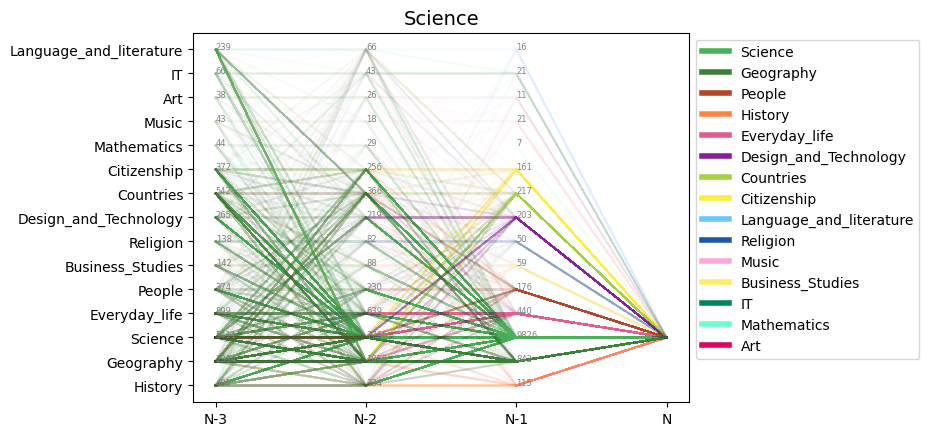

In [ ]:
plot_path(new_path_dict, 'Science')
#for cat in path_dict.keys():
    #plot_path(new_path_dict, cat)

In [ ]:
"""
fig,axes = plt.subplots(8,2, figsize=(50,100))
axes = axes.flatten()

i=0
for cat in path_dict.keys():
    line_width = 50/len(path_dict[cat])
    for path in path_dict[cat]:
        x_path = np.arange(start = 4 - len(path), stop = 4, step = 1)
        axes[i].plot(x_path, path,color = color_dict[cat], alpha = line_width)
    axes[i].set_title(cat, size = 20)
    axes[i].set_xticks(np.arange(4), ['N-3', 'N-2', 'N-1', 'N'])
    axes[i].tick_params(labelsize = 18)
    i+=1
plt.tight_layout()
plt.show()
"""

"\nfig,axes = plt.subplots(8,2, figsize=(50,100))\naxes = axes.flatten()\n\ni=0\nfor cat in path_dict.keys():\n    line_width = 50/len(path_dict[cat])\n    for path in path_dict[cat]:\n        x_path = np.arange(start = 4 - len(path), stop = 4, step = 1)\n        axes[i].plot(x_path, path,color = color_dict[cat], alpha = line_width)\n    axes[i].set_title(cat, size = 20)\n    axes[i].set_xticks(np.arange(4), ['N-3', 'N-2', 'N-1', 'N'])\n    axes[i].tick_params(labelsize = 18)\n    i+=1\nplt.tight_layout()\nplt.show()\n"

## Distribution of the starting and finishing pages of the paths

### Retrieve the data

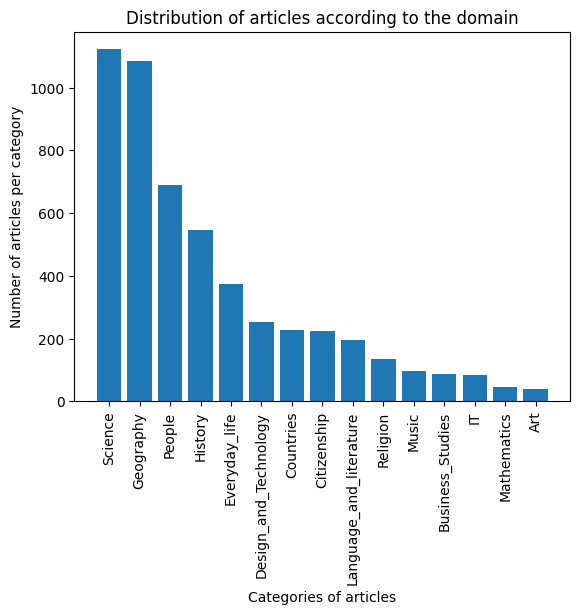

In [ ]:
# First copy the data_frame
reduced_categories = categories.copy(deep=True)

# Extract the reduced categories and add them to the copied df
reduced_categories_list = [category.replace('subject.', '').split('.')[0] for category in reduced_categories['category']]
reduced_categories = reduced_categories.assign(simple_category = reduced_categories_list)

# Count the new distribution and plot it
category_distribution = reduced_categories['simple_category'].value_counts()

fig, ax = plt.subplots()
ax.bar(category_distribution.index, category_distribution.values)
ax.set_ylabel('Number of articles per category')
ax.set_xlabel('Categories of articles')
ax.set_xticks(np.arange(len(category_distribution.values)), category_distribution.index, rotation = 90)
ax.set_title('Distribution of articles according to the domain')
plt.show()

In [ ]:
paths_finished = dfs['paths_finished']

starting_points = pd.DataFrame([path.split(';')[0] for path in paths_finished['path']])
finishing_points = pd.DataFrame([path.split(';')[-1] for path in paths_finished['path']])

starting_counts = pd.DataFrame(starting_points.value_counts())
finishing_counts = pd.DataFrame(finishing_points.value_counts())

starting_list = [start[0] for start in starting_counts.index.tolist()]
finishing_list = [finish[0] for finish in finishing_counts.index.tolist()]

start_cat = [reduced_categories.loc[reduced_categories['article'] == start,'simple_category'].values.tolist() for start in starting_list]
finish_cat = [reduced_categories.loc[reduced_categories['article'] == finish,'simple_category'].values.tolist() for finish in finishing_list]

In [ ]:
new_start_cat = start_cat
for i in range(len(start_cat)):
    if len(start_cat[i])>1:
        new_start_cat[i] = [start_cat[i][0]]
new_start_cat = [' '.join(cat) for cat in new_start_cat]

new_finish_cat = finish_cat
for i in range(len(finish_cat)):
    if len(finish_cat[i])>1:
        new_finish_cat[i] = [finish_cat[i][0]]
new_finish_cat = [' '.join(cat) for cat in new_finish_cat]

starting_counts = starting_counts.assign(simple_category = new_start_cat)
finishing_counts = finishing_counts.assign(simple_category = new_finish_cat)

starting_counts.columns = ['count', 'simple_category']
finishing_counts.columns = ['count', 'simple_category']


### Plot the data

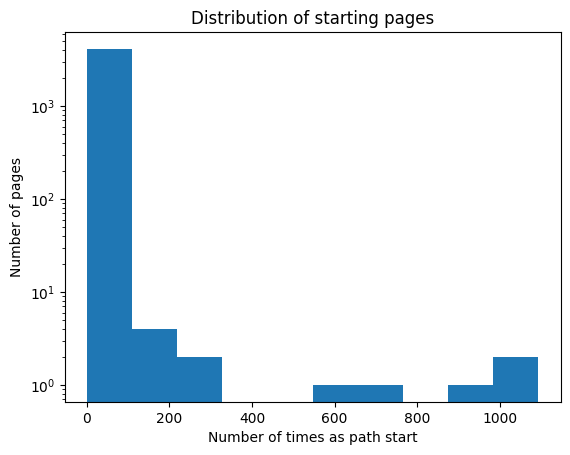

In [ ]:
plt.hist(starting_counts['count'], 10)
plt.xlabel('Number of times as path start')
plt.ylabel('Number of pages')
plt.title('Distribution of starting pages')
plt.yscale('log')
plt.show()

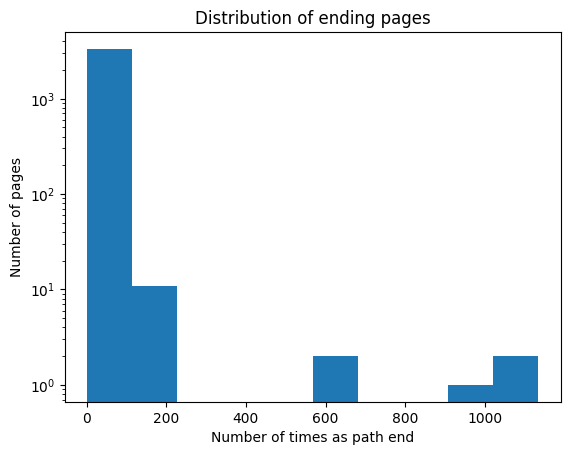

In [ ]:
plt.hist(finishing_counts['count'], 10)
plt.xlabel('Number of times as path end')
plt.ylabel('Number of pages')
plt.title('Distribution of ending pages')
plt.yscale('log')
plt.show()

### Get the categories

In [ ]:
starting_counts_condensed = starting_counts.groupby(starting_counts['simple_category']).aggregate('count').sort_values('count')
finishing_counts_condensed = finishing_counts.groupby(finishing_counts['simple_category']).aggregate('count').sort_values('count')

### Plot the categories

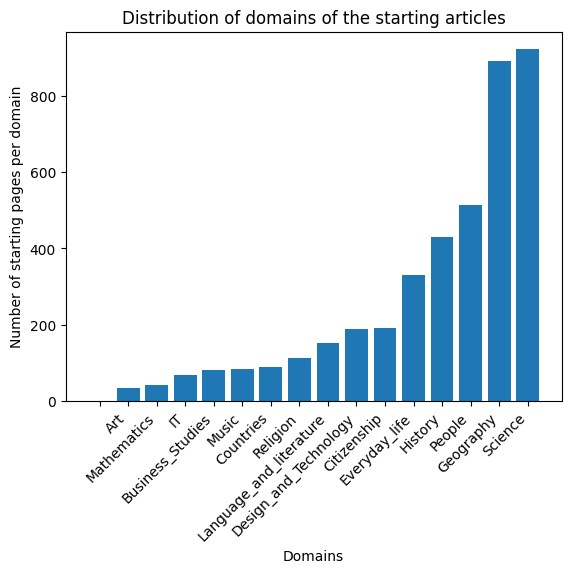

In [ ]:
fig, ax = plt.subplots()
ax.bar(starting_counts_condensed.index, starting_counts_condensed['count'])
ax.set_ylabel('Number of starting pages per domain')
ax.set_xlabel('Domains')
ax.set_xticks(np.arange(len(starting_counts_condensed.index)),starting_counts_condensed.index, rotation = 45, ha='right')
ax.set_title('Distribution of domains of the starting articles')
plt.show()

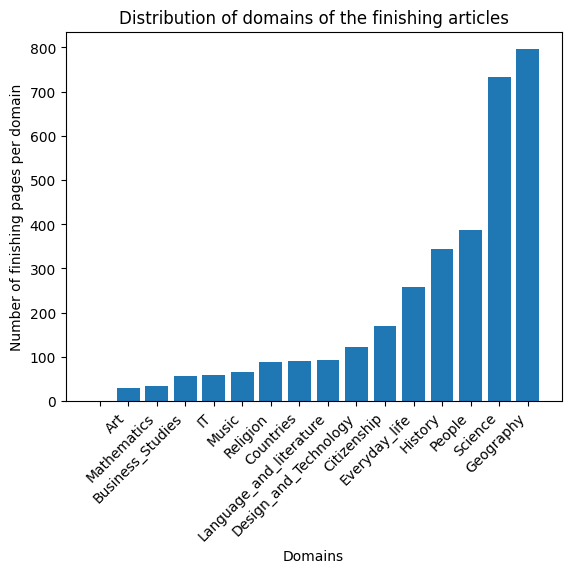

In [ ]:
fig, ax = plt.subplots()
ax.bar(finishing_counts_condensed.index, finishing_counts_condensed['count'])
ax.set_ylabel('Number of finishing pages per domain')
ax.set_xlabel('Domains')
ax.set_xticks(np.arange(len(finishing_counts_condensed.index)),finishing_counts_condensed.index, rotation = 45, ha='right')
ax.set_title('Distribution of domains of the finishing articles')
plt.show()

In [ ]:
start_cat = pd.DataFrame(starting_counts_condensed.reset_index()['simple_category'])
finish_cat = finishing_counts_condensed.reset_index()['simple_category']

start_index = start_cat.index

finish_index = (finish_cat.index.get_loc(cat) for cat in start_cat['simple_category'])


## Let's have a closer look at the paths

In [ ]:
paths = paths_finished.drop(['timestamp','durationInSec'], axis = 1)

### Now let's focus on gender

In [ ]:
main_people_selection_single = main_people_selection.reset_index().drop_duplicates(subset = ['article'], keep='first').set_index('article')

In [ ]:

starting_counts_people = pd.DataFrame(starting_counts.loc[starting_counts['simple_category'] == 'People']).drop('simple_category', axis=1)
finishing_counts_people = pd.DataFrame(finishing_counts.loc[finishing_counts['simple_category'] == 'People'].drop('simple_category', axis=1))
starting_counts_people['gender'] = [main_people_selection_single.loc[person]['gender'] for person in starting_counts_people.index]
finishing_counts_people['gender'] = [main_people_selection_single.loc[person]['gender'] for person in finishing_counts_people.index]

In [ ]:
main_people_selection_single = main_people_selection.reset_index().drop_duplicates(subset = ['article'], keep='first').set_index('article')

There are  457  different starting males.
There are  40  different starting females.
There are  18  different starting unknowns.


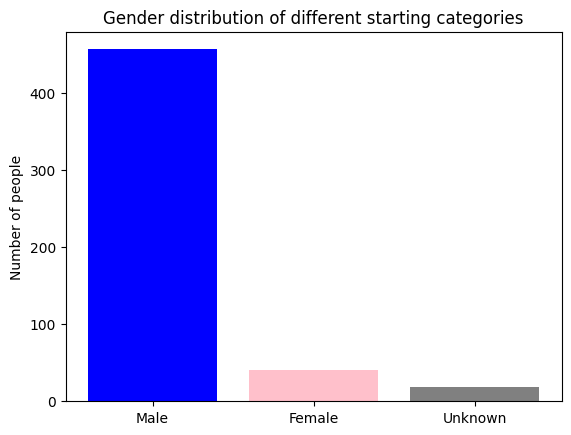

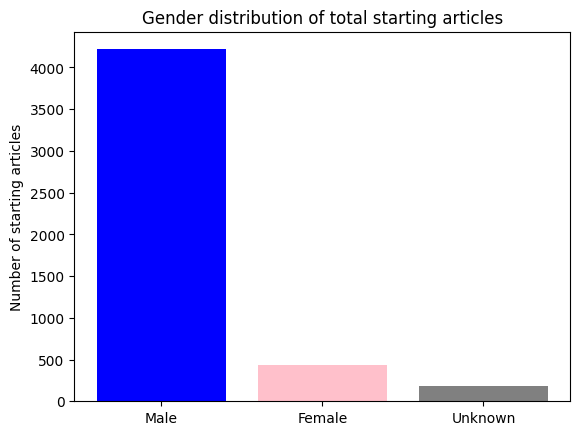

In [ ]:
starting_gender_counts_fem = starting_counts_people[starting_counts_people['gender'] == 'Female']
starting_gender_counts_male = starting_counts_people[starting_counts_people['gender'] == 'Male']
starting_gender_counts_unk = starting_counts_people[starting_counts_people['gender'] == 'Unknown']
print('There are ' ,len(starting_gender_counts_male), ' different starting males.')
print('There are ' ,len(starting_gender_counts_fem), ' different starting females.')
print('There are ' ,len(starting_gender_counts_unk), ' different starting unknowns.')

plt.bar(x=(0,1,2),height=(len(starting_gender_counts_male),len(starting_gender_counts_fem),len(starting_gender_counts_unk)), color = ('blue', 'pink', 'grey'))
plt.ylabel('Number of people')
plt.xticks(ticks = (0,1,2), labels = ('Male', 'Female', 'Unknown'))
plt.title('Gender distribution of different starting categories')
plt.show()

plt.bar(x=(0,1,2), height = (starting_gender_counts_male['count'].sum(),starting_gender_counts_fem['count'].sum(),starting_gender_counts_unk['count'].sum()), color = ('blue', 'pink', 'grey'))
plt.ylabel('Number of starting articles')
plt.xticks(ticks = (0,1,2), labels = ('Male', 'Female', 'Unknown'))
plt.title('Gender distribution of total starting articles')
plt.show()

There are  346  different finishing males.
There are  29  different finishing females.
There are  12  different finishing unknowns.


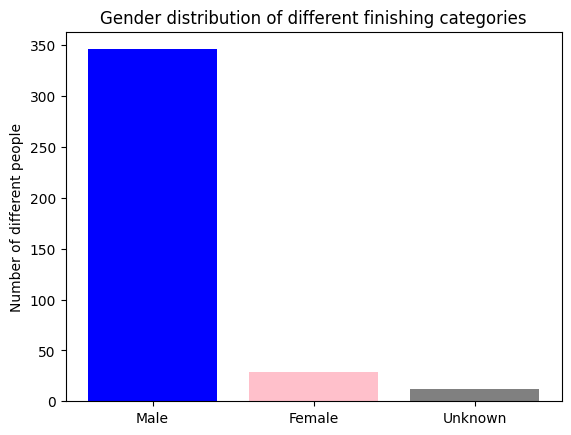

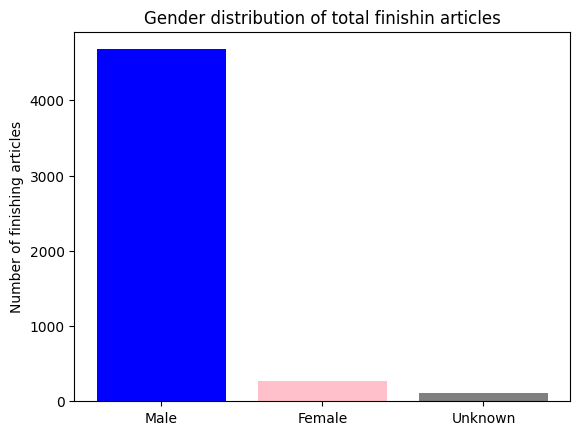

In [ ]:
finishing_gender_counts_fem = finishing_counts_people[finishing_counts_people['gender'] == 'Female']
finishing_gender_counts_male = finishing_counts_people[finishing_counts_people['gender'] == 'Male']
finishing_gender_counts_unk = finishing_counts_people[finishing_counts_people['gender'] == 'Unknown']
print('There are ' ,len(finishing_gender_counts_male), ' different finishing males.')
print('There are ' ,len(finishing_gender_counts_fem), ' different finishing females.')
print('There are ' ,len(finishing_gender_counts_unk), ' different finishing unknowns.')

plt.bar(x=(0,1,2),height=(len(finishing_gender_counts_male),len(finishing_gender_counts_fem),len(finishing_gender_counts_unk)), color = ('blue', 'pink', 'grey'))
plt.ylabel('Number of different people')
plt.xticks(ticks = (0,1,2), labels = ('Male', 'Female', 'Unknown'))
plt.title('Gender distribution of different finishing categories')
plt.show()

plt.bar(x=(0,1,2), height = (finishing_gender_counts_male['count'].sum(),finishing_gender_counts_fem['count'].sum(),finishing_gender_counts_unk['count'].sum()), color = ('blue', 'pink', 'grey'))
plt.ylabel('Number of finishing articles')
plt.xticks(ticks = (0,1,2), labels = ('Male', 'Female', 'Unknown'))
plt.title('Gender distribution of total finishing articles')
plt.show()

# to do : print categories of the people in finishing vs starting paths

# Connection graphs of the links

#### List of paths to access the articles htm

In [ ]:
list_articles_paths = []

# Iterate through all htm file in all sub-folder from main folder wp 
for root, dirs, subfolders in os.walk('dataset/wpcd/wp/'):
    for file in subfolders:
        # Select only the htm files
        if file.endswith('.htm'):
            file_path = os.path.join(root, file)
            # Store only select the htm usefull for the game 
            if '/index/' not in file_path:
                list_articles_paths.append(file_path)
list_articles_paths[:10]

[]

# Connection graphs of graphs

In [ ]:
def connection_graph(html_files, nodes_name, categories, people_names,  fs = (15, 10), node_sz=20, font_sz=12, color_pal = "colorblind", title = '', directional = False, label = False,  people = False, plot = True):
    start_time = datetime.now()

    category_table = categories.copy()

    # Create a graph
    if directional: 
        graph = nx.MultiDiGraph()
    else:
        graph = nx.MultiGraph()

    # Iterate through HTML files and extract links
    for html_file in html_files: 
        # Extract all the unique link of the htm file
        links = extract_links(html_file)

        # Extract the source article name
        source_name = path_to_name(html_file)

        if not people:
            for link in set(links):
                # Extract the reached article name
                target_name = path_to_name(link)

                # Add edges to the graph
                graph.add_edge(source_name, target_name)

        # In case we only want people names pages      
        elif source_name in people_names:
            for link in set(links):
                # Extract the reached article name
                target_name = path_to_name(link)

                # Add edges to the graph
                graph.add_edge(source_name, target_name)
    
    # Add category to the nodes
    nodes = pd.Series(list(graph.nodes))
    art_cat = pd.merge(category_table, nodes.rename('article'), how='right', on='article')
    art_cat['category'].fillna('unkown', inplace=True)
    graph.add_nodes_from(art_cat.article)
    
    # Colors corresponding to the categories 
    colors = sns.color_palette(color_pal, n_colors=len(art_cat.category.unique()))
    category_color_dict = {category: colors[i] for i, category in enumerate(art_cat['category'].unique())}
    node_colors = [category_color_dict[category] for category in art_cat['category']]

    
    # Plot or not
    if plot: 

        plt.figure(figsize=fs)

        pos = nx.spring_layout(graph) 
        #nx.draw(graph, pos, with_labels=label, node_color=node_colors,  node_size=node_sz, font_size=font_sz, edge_color='black', alpha=0.5)

        nx.draw_networkx_nodes(graph, pos, node_color=node_colors, node_size=node_sz)

        # Draw the edges with another alpha value
        nx.draw_networkx_edges(graph, pos, alpha=0.5)

        if label:
            # Draw labels separately without alpha
            nx.draw_networkx_labels(graph, pos, font_size=font_sz)

        # Legend 
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in category_color_dict.values()]
        labels = [str(category) for category in category_color_dict.keys()]
        plt.legend(handles, labels, title='Categories', loc = 'upper left', bbox_to_anchor=(1, 1))  
        plt.title(title)
        plt.axis('off')

        plt.show()
    
    else:
        print('Duration create_connection_graph for {} html files: {}'.format(len(html_files), datetime.now() - start_time))
        return graph, node_colors

In [ ]:
main_categories = dfs['categories'].copy()

# Selection of the article list of people
people_list = main_categories.copy()[main_categories['category'].str.contains('subject.People')]
people_list = list(people_list.article)

# Main categories of all articles 
main_categories.category = [cat.split('.')[1] for cat in main_categories.category]
# Some of them have two main categories, for now I just select the first one that appear 
main_categories = main_categories.groupby('article')['category'].first().reset_index()

# Color selection for all the main categories
color_ = ["#F3C300", "#875692", "#F38400", "#A1CAF1", "#BE0032", "#C2B280", "#848482" ,"#008856", "#E68FAC", "#0067A5" ,"#F99379" ,"#604E97", "#F6A600" ,"#B3446C", "#DCD300", "#882D17", "#8DB600" ,"#654522","#E25822" ,"#2B3D26"]


### Article graphs

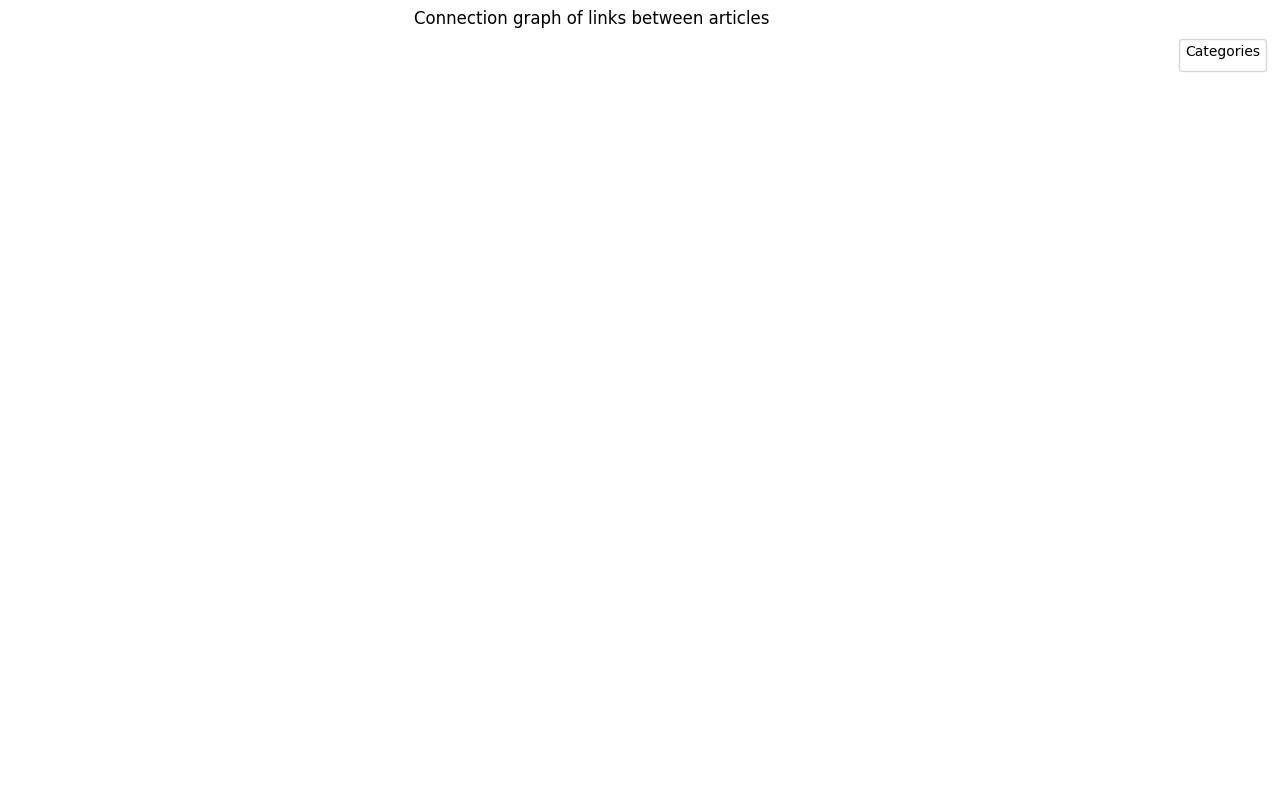

In [ ]:
connection_graph(list_articles_paths, dfs['article']['article'], main_categories, 0, (15,10), node_sz=30, font_sz=12 , 
                        color_pal = color_, title = 'Connection graph of links between articles', directional = False, label = False,  people = False, plot = True)

Due to the large number of articles used, it is difficult to observe specific things. At least, we can observed that most article are linked together. A small cluster of unkown categories can be observed. 

### People article graphs 

Connection graph of the links from 2 famous people pages (Richard Wagner & Rudyard Kipling).


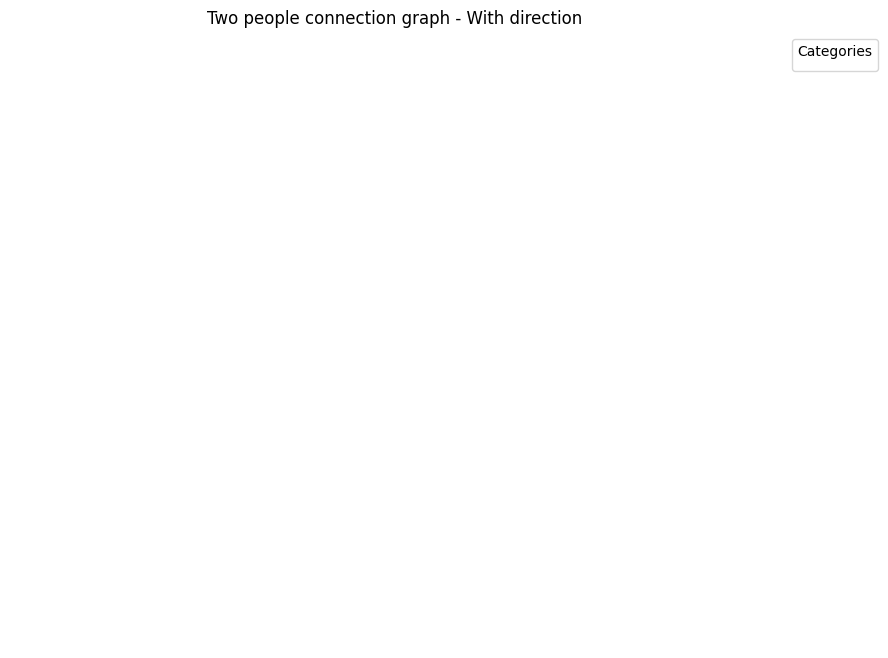

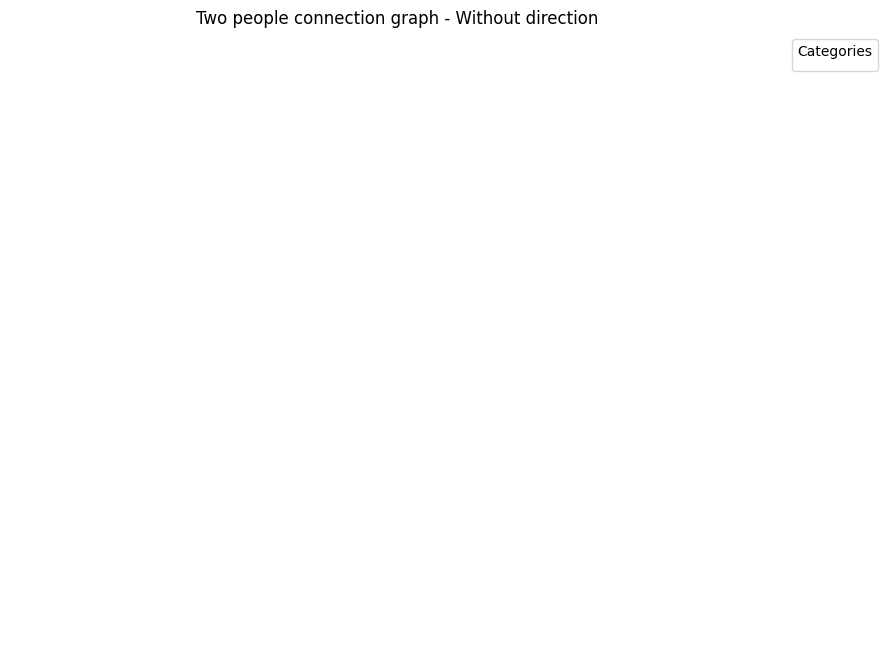

In [ ]:

print('Connection graph of the links from 2 famous people pages (Richard Wagner & Rudyard Kipling).')
connection_graph(list_articles_paths[:18], dfs['article']['article'], main_categories, people_list, (10,8), node_sz=40, font_sz=12 , 
                        color_pal = color_, title = 'Two people connection graph - With direction ', directional = True, label = True,  people = True, plot = True)

connection_graph(list_articles_paths[:18], dfs['article']['article'], main_categories, people_list, (10,8), node_sz=40, font_sz=12 , 
                        color_pal = color_, title = 'Two people connection graph - Without direction', directional = False, label = True,  people = True, plot = True)

Here, we have a visualisation of the links present in the page of two people. Even for a small number of page, with the name of the nodes (articles), it is difficult to read. We are interested to see if some cluster of domain are observed, so we will only look at the categories and not the article names. 

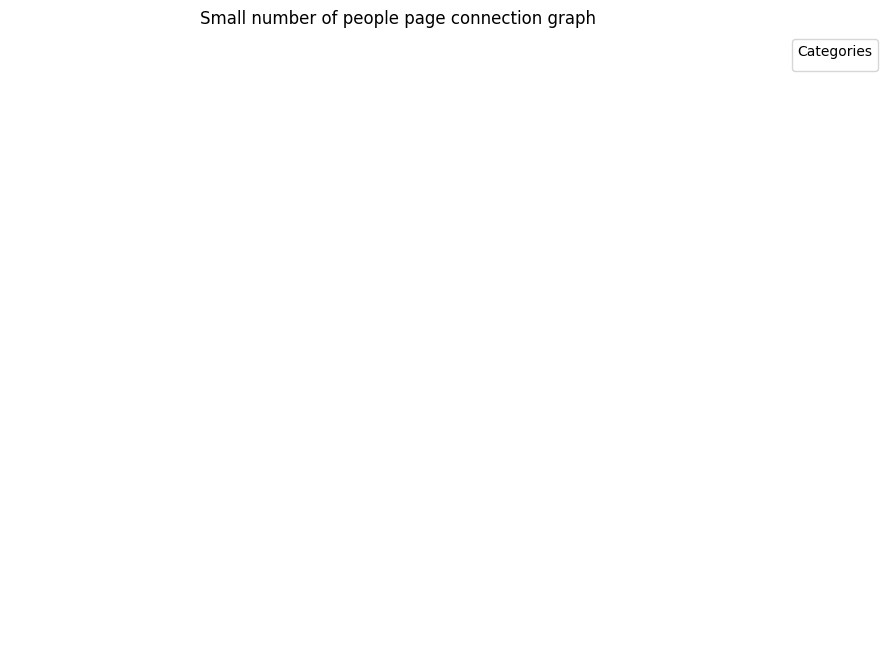

In [ ]:
connection_graph(list_articles_paths[:100], dfs['article']['article'], main_categories, people_list, (10,8), node_sz=40, font_sz=12 , 
                        color_pal = color_, title = 'Small number of people page connection graph', directional = False, label = False,  people = True, plot = True)

By incresing the number of people pages, we can start to notice some distinctions. By instance, some peoples seem more to be related to people than others. 

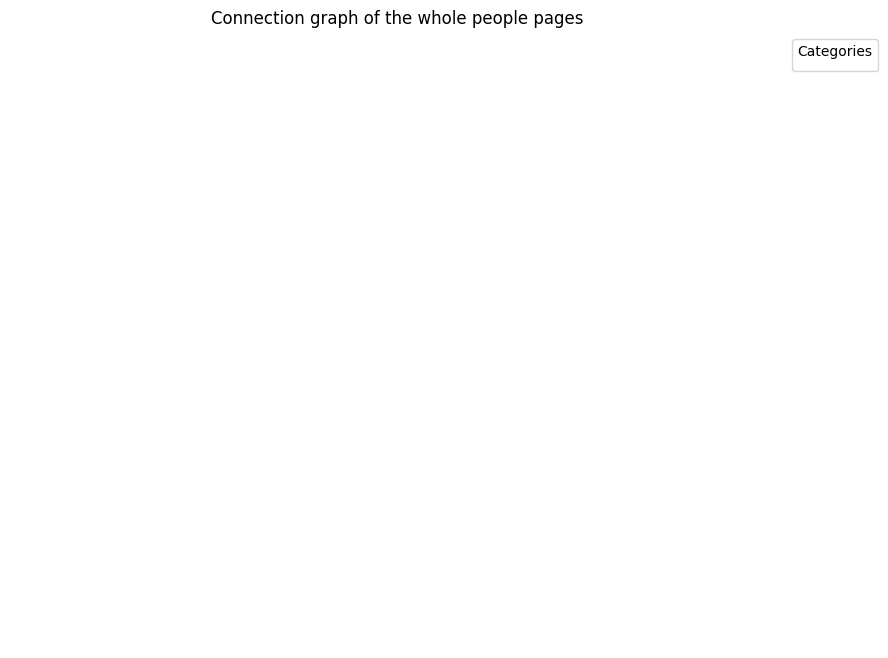

In [ ]:
connection_graph(list_articles_paths, dfs['article']['article'], main_categories, people_list, (10,8) , 
                        color_pal = color_, title = 'Connection graph of the whole people pages', directional = False, label = False,  people = True, plot = True)

As for the whole article plot, extracting information from the links across all people's pages is difficult due to the large number of points (require an interactive connection graph). However, at least we can observe the absence of clusters of domains.